<a href="https://colab.research.google.com/github/SKYHAWK993/LogBasedAnomalyDetection/blob/main/log_based_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Thijsvanede/DeepLog.git
%cd DeepLog

fatal: destination path 'DeepLog' already exists and is not an empty directory.
/content/DeepLog


In [ ]:
!pip install tensorflow numpy pandas scikit-learn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!wget https://raw.githubusercontent.com/logpai/loghub/master/Linux/Linux_2k.log

--2025-03-21 05:59:29--  https://raw.githubusercontent.com/logpai/loghub/master/Linux/Linux_2k.log
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216485 (211K) [text/plain]
Saving to: ‘Linux_2k.log.2’

Linux_2k.log.2      100%[===================>] 211.41K  --.-KB/s    in 0.03s   

2025-03-21 05:59:29 (7.03 MB/s) - ‘Linux_2k.log.2’ saved [216485/216485]



In [44]:
from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig

# Configuration for Drain3
config = TemplateMinerConfig()
#config.masking = [
#    {"regex_pattern": r"\d+", "mask_with": "<NUM>"},
#    {"regex_pattern": r"([A-Fa-f0-9]{2}-){5}[A-Fa-f0-9]{2}", "mask_with": "<MAC>"},
#]

#custom configs
config.masking = [
    {"regex_pattern": r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}", "mask_with": "<TIMESTAMP>"},
    {"regex_pattern": r"[A-Za-z]{3} \d{1,2} \d{2}:\d{2}:\d{2}", "mask_with": "<TIMESTAMP>"},
    {"regex_pattern": r"\[\d+\]", "mask_with": "<PID>"},
    {"regex_pattern": r"\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b", "mask_with": "<IP>"},
    {"regex_pattern": r"\b[a-fA-F0-9:]+:+[a-fA-F0-9:]+\b", "mask_with": "<IPv6>"},
    {"regex_pattern": r"for user \S+", "mask_with": "for user <USER>"},
    {"regex_pattern": r"port \d+", "mask_with": "port <PORT>"},
    {"regex_pattern": r":\d{2,5}", "mask_with": ":<PORT>"},
    {"regex_pattern": r"(/[^ ]+)+", "mask_with": "<FILE_PATH>"},
    {"regex_pattern": r"\b(200|301|302|400|401|403|404|500|502|503)\b", "mask_with": "<HTTP_CODE>"},
    {"regex_pattern": r"COMMAND=\S+", "mask_with": "COMMAND=<CMD>"},
    {"regex_pattern": r"USER=\S+", "mask_with": "USER=<USER>"}
]


# Initialize Drain3
template_miner = TemplateMiner(config=config)

# Parse logs
log_file = "Linux_2k.log"
parsed_logs = []

with open(log_file, "r") as f:
    for line in f:
        line = line.strip()
        result = template_miner.add_log_message(line)
        if result["change_type"]:
            print(f"New template detected: {result['template_mined']}")
        parsed_logs.append(result["template_mined"])

# Save parsed templates
templates = list(template_miner.drain.clusters)
print(f"Total templates extracted: {len(templates)}")

New template detected: Jun 14 15:16:01 combo sshd(pam_unix)[19939]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=218.188.2.4
New template detected: Jun 14 15:16:02 combo sshd(pam_unix)[19937]: check pass; user unknown
New template detected: Jun 14 <*> combo <*> authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=218.188.2.4
New template detected: Jun 15 02:04:59 combo sshd(pam_unix)[20882]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=220-135-151-1.hinet-ip.hinet.net user=root
New template detected: Jun 15 02:04:59 combo <*> authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=220-135-151-1.hinet-ip.hinet.net user=root
New template detected: Jun 15 02:04:59 combo <*> authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=220-135-151-1.hinet-ip.hinet.net user=root
New template detected: Jun 15 02:04:59 combo <*> authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= r

In [46]:
# Map templates to IDs
template_id_map = {template: idx for idx, template in enumerate(templates)}
log_sequences = []

for template in parsed_logs:
    # Check if the template is present in the template_id_map
    if template in template_id_map:
        log_sequences.append(template_id_map[template])
    else:
        # Handle cases where the template is not found by assigning to unknown token id
        # Assume that template_id_map starts from 0 and increment by 1
        log_sequences.append(len(template_id_map))
        # Add the unseen template to template_id_map
        template_id_map[template] = len(template_id_map)


# Create sliding window sequences
window_size = 10  # Adjust based on your dataset
X, y = [], []

for i in range(len(log_sequences) - window_size):
    X.append(log_sequences[i:i + window_size])
    y.append(log_sequences[i + window_size])  # Next log event as the target

# Convert to numpy arrays
import numpy as np
X = np.array(X)
y = np.array(y)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
import torch
import torch.nn as nn

class DeepLog(nn.Module):
    def __init__(self, num_classes, hidden_size=64, num_layers=2, window_size=10):
        super(DeepLog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.window_size = window_size

        # Embedding layer
        self.embedding = nn.Embedding(num_classes, hidden_size)

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Embed the input
        x = self.embedding(x)

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [49]:
# Initialize the model
model = DeepLog(
    num_classes=len(template_id_map),  # Number of unique log templates
    hidden_size=64,              # Size of the LSTM hidden state
    num_layers=2,                # Number of LSTM layers
    window_size=window_size      # Sliding window size
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        # Get mini-batch
        inputs = X_train[i:i + batch_size]
        labels = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 3.0678
Epoch [2/10], Loss: 1.8211
Epoch [3/10], Loss: 1.4904
Epoch [4/10], Loss: 1.2981
Epoch [5/10], Loss: 1.1481
Epoch [6/10], Loss: 1.0166
Epoch [7/10], Loss: 0.9127
Epoch [8/10], Loss: 0.8348
Epoch [9/10], Loss: 0.7685
Epoch [10/10], Loss: 0.7083


In [50]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")

anomalies = predicted != y_test
print(f"Total anomalies detected: {sum(anomalies).item()}")

Test Accuracy: 0.7337
Total anomalies detected: 106


In [51]:
# Find indices of anomalies
anomalous_indices = torch.nonzero(anomalies).squeeze().tolist()
# Reverse mapping of event IDs to log templates
id_to_template = {v: k for k, v in template_id_map.items()}
print("\nDetected Anomalous Logs:\n")
for idx in anomalous_indices:
    actual_event_id = y_test[idx].item()
    predicted_event_id = predicted[idx].item()

    actual_template = id_to_template.get(actual_event_id, "Unknown Template")
    predicted_template = id_to_template.get(predicted_event_id, "Unknown Template")

    print(f"Index: {idx}")
    print(f"Actual Log Template  : {actual_template}")
    print(f"Predicted Log Template: {predicted_template}")
    print("-" * 80)



Detected Anomalous Logs:

Index: 0
Actual Log Template  : Jul <*> <*> combo <*> session opened for user <*> by <*>
Predicted Log Template: Jul <*> <*> combo <*> session closed for user <*>
--------------------------------------------------------------------------------
Index: 9
Actual Log Template  : Jul 25 <*> combo named[2306]: notify question section contains no SOA
Predicted Log Template: Jul <*> <*> combo <*> connection from <*> <*> at <*> Jul <*> <*> 2005
--------------------------------------------------------------------------------
Index: 10
Actual Log Template  : Jun <*> <*> combo <*> connection from <*> <*> at <*> Jun <*> <*> 2005
Predicted Log Template: Jun <*> <*> combo <*> authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= <*> <*>
--------------------------------------------------------------------------------
Index: 11
Actual Log Template  : Jun <*> <*> combo <*> connection from <*> <*> at <*> Jun <*> <*> 2005
Predicted Log Template: Jun <*> <*> combo <*>

<ipython-input-56-08f4594f75f0>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts, y=event_names, palette="Reds_r")


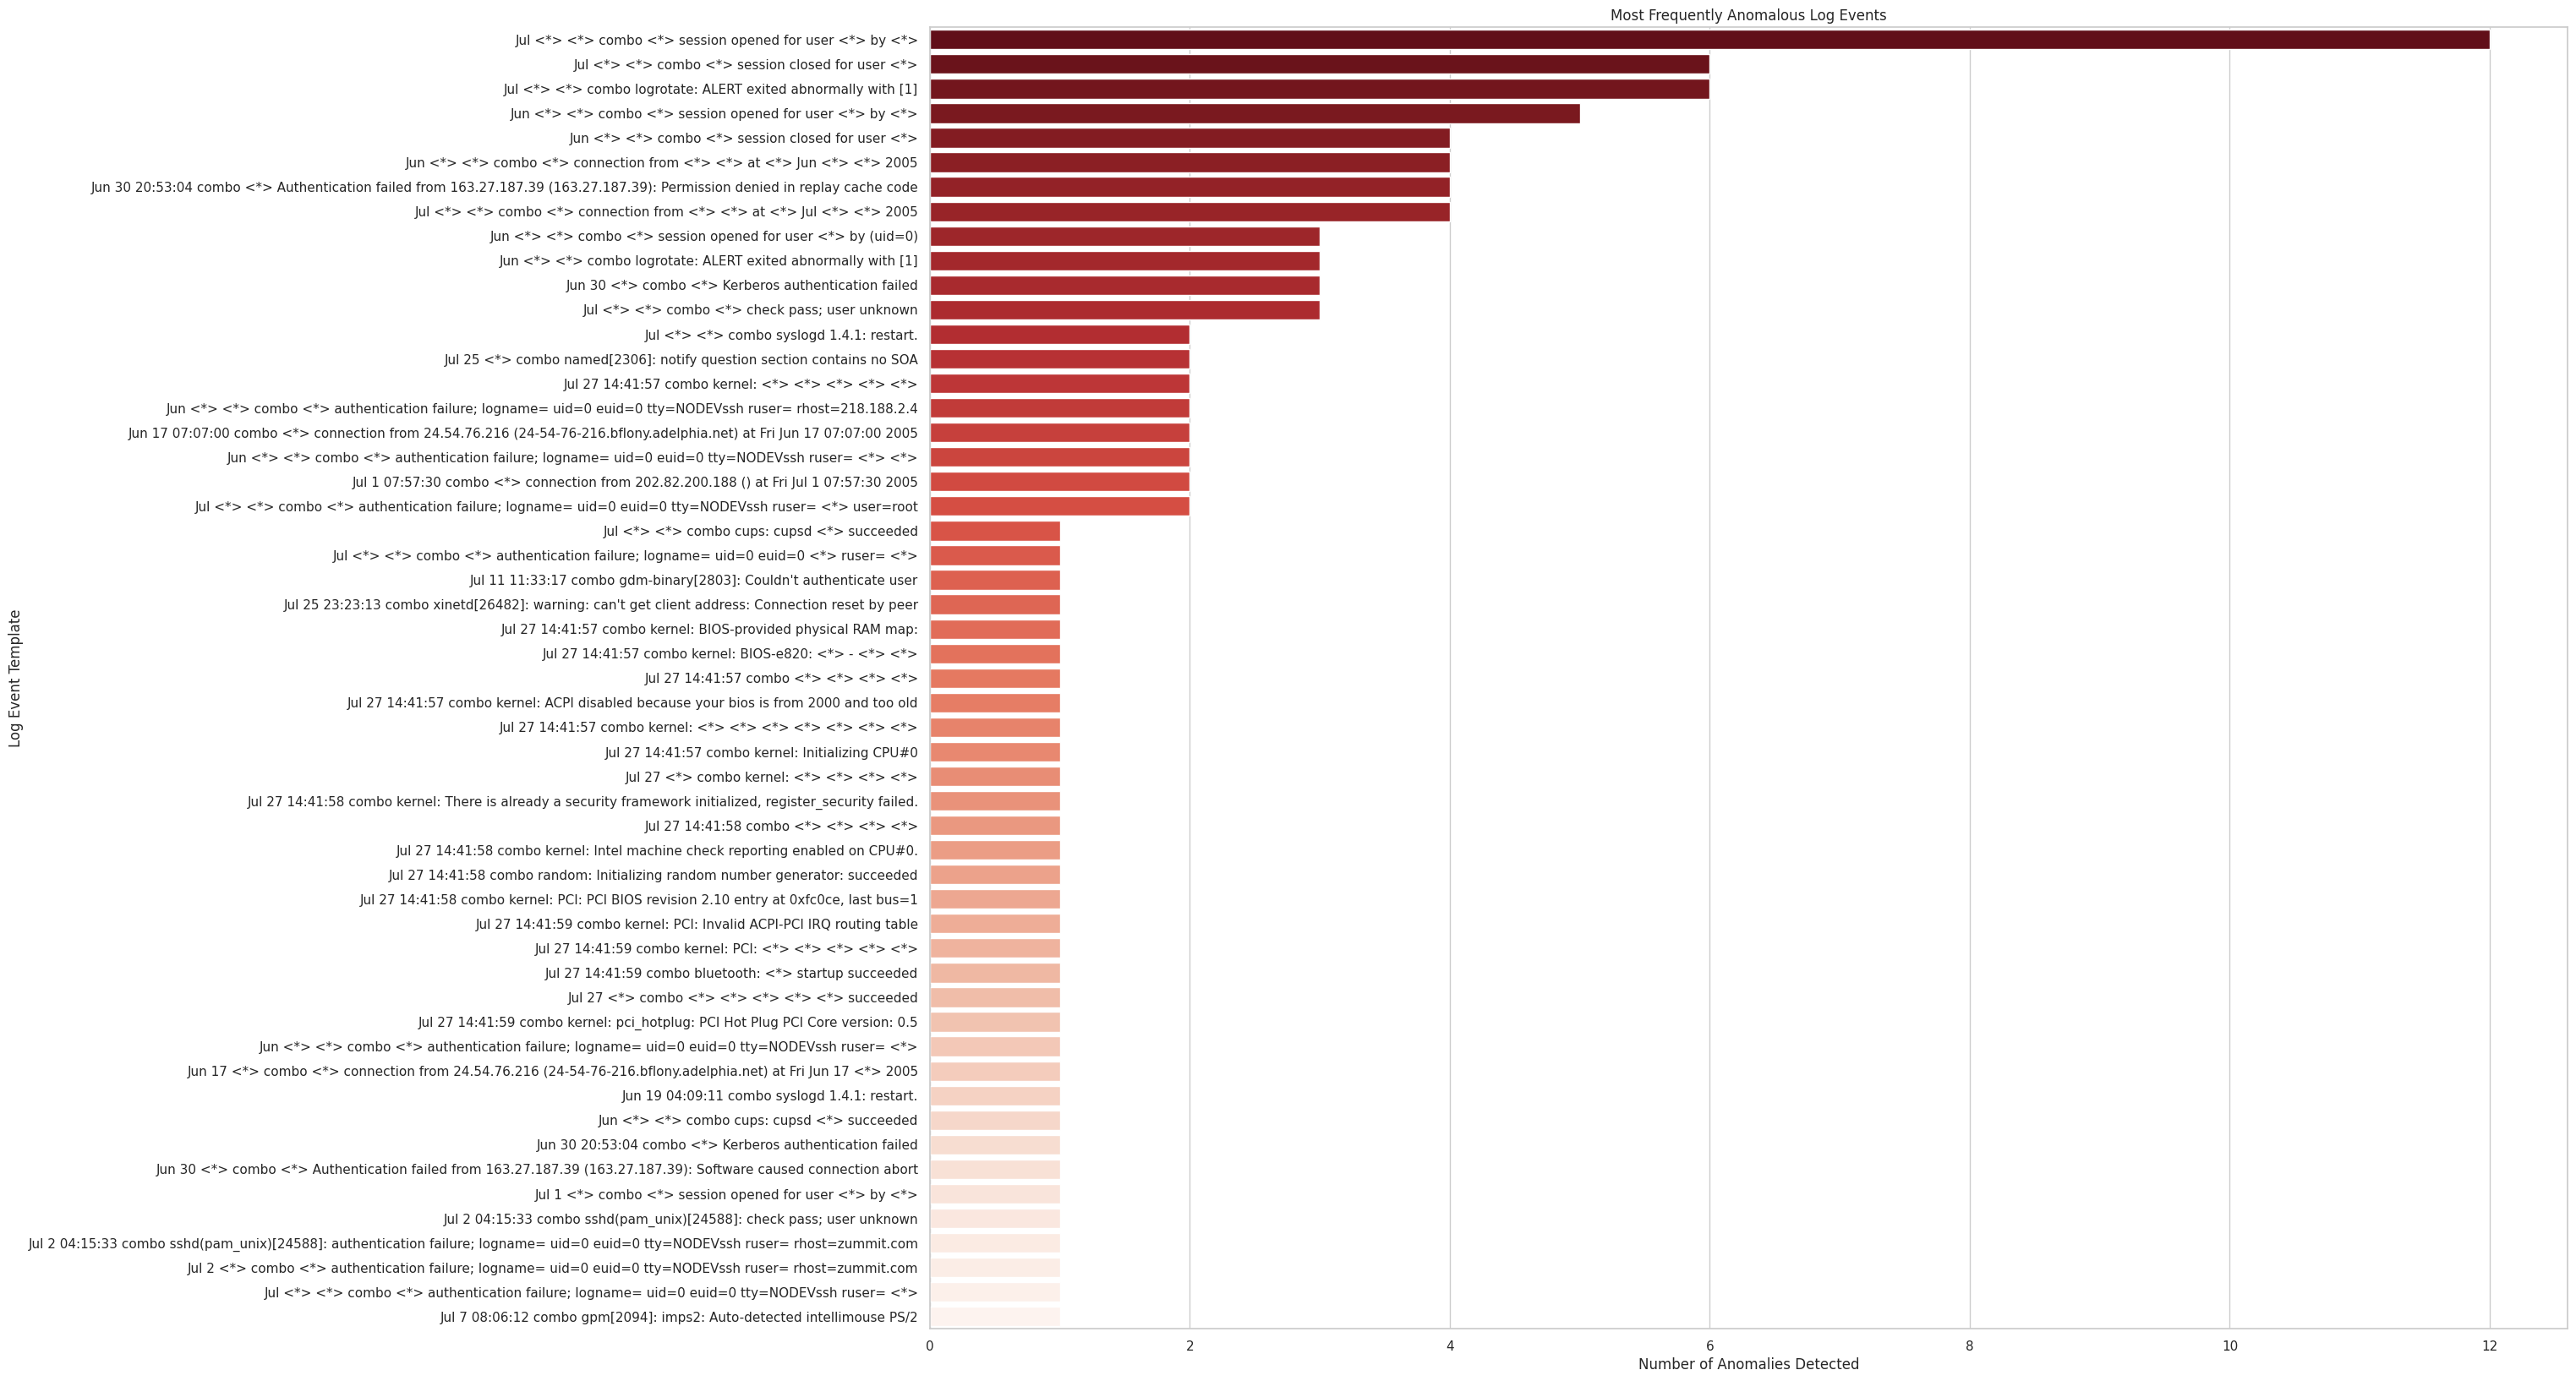

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn has a clean style
sns.set(style="whitegrid")

# Convert tensors to numpy for plotting
y_test_np = y_test.numpy()
predicted_np = predicted.numpy()
anomalous_indices = np.where(y_test_np != predicted_np)[0]

# Reverse mapping of event IDs to log templates
id_to_template = {v: k for k, v in template_id_map.items()}

# Plot 1: Actual vs. Predicted Log Event IDs
#plt.figure(figsize=(12, 6))
#plt.plot(range(len(y_test_np)), y_test_np, label="Actual Event ID", color="blue", alpha=0.6)
#plt.plot(range(len(predicted_np)), predicted_np, label="Predicted Event ID", color="red", linestyle="dashed", alpha=0.6)
#plt.scatter(anomalous_indices, y_test_np[anomalous_indices], color="black", marker='x', label="Anomalies")
#
#plt.xlabel("Log Sequence Index")
#plt.ylabel("Event ID")
#plt.title("Actual vs Predicted Log Event IDs with Anomalies")
#plt.legend()
#plt.show()
#
## Plot 2: Anomalies Highlighted on the Timeline
#plt.figure(figsize=(12, 5))
#plt.plot(range(len(y_test_np)), y_test_np, label="Log Event IDs", color="gray", alpha=0.4)
#plt.scatter(anomalous_indices, y_test_np[anomalous_indices], color="red", label="Anomalies", marker='x')
#
#plt.xlabel("Log Sequence Index")
#plt.ylabel("Event ID")
#plt.title("Anomaly Detection in Log Sequences")
#plt.legend()
#plt.show()

# Plot 3: Anomaly Count per Event ID
anomalous_events = y_test_np[anomalous_indices]
anomaly_counts = {id_to_template[event_id]: list(anomalous_events).count(event_id) for event_id in set(anomalous_events)}

# Sort by most frequent anomalies
sorted_anomalies = sorted(anomaly_counts.items(), key=lambda x: x[1], reverse=True)

# Extract names and counts for plotting
event_names = [item[0] for item in sorted_anomalies]
event_counts = [item[1] for item in sorted_anomalies]

# Bar plot
plt.figure(figsize=(25, 20))
sns.barplot(x=event_counts, y=event_names, palette="Reds_r")
plt.xlabel("Number of Anomalies Detected")
plt.ylabel("Log Event Template")
plt.title("Most Frequently Anomalous Log Events")
plt.show()





